In [440]:
import uuid
from pathlib import Path

import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import torch
import torch.nn as nn
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc

from dataloaders.tabular import TabularDataset
from experiments.anomaly_detection import AnomalyDetection
from experiments.dnn_ae_experiment import DNNAEExperiment
from models.dnn_ae import Autoencoder
from niapy_extension.wrapper import *
import numpy as np
import sqlite3
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.metrics import accuracy_score

### Setup configuration

In [441]:
RUN_UUID = uuid.uuid4().hex

with open("configs/dnn_ae.yaml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

config['logging_params']['save_dir'] += RUN_UUID + '/'
Path(config['logging_params']['save_dir']).mkdir(parents=True, exist_ok=True)
seed_everything(config['exp_params']['manual_seed'], True)
datamodule = TabularDataset(**config["data_params"], pin_memory=True)
datamodule.setup()

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\pytorch_lightning\utilities\seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 1265


### 2D Scatter plot (anomalies vs. normal)

In [442]:
datamodule = TabularDataset(**config["data_params"], pin_memory=True)
datamodule.setup()
x = datamodule.test_dataset.x_test.cpu().detach().numpy()
y = datamodule.test_dataset.y_test.cpu().detach().numpy()
x.shape

(530, 60)

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


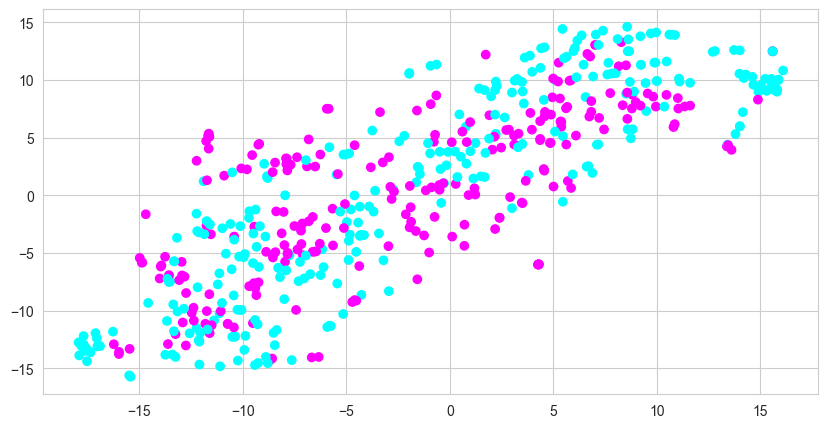

In [443]:
# https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c
X_tsne = TSNE(n_components=2, learning_rate=1000, n_iter=1000, perplexity=60).fit_transform(x)
X_pca = PCA().fit_transform(x)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:x.shape[0]], cmap='cool')
plt.savefig('normal_and_anomalies_2d.png', dpi=300)

### Construct model and experiment

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


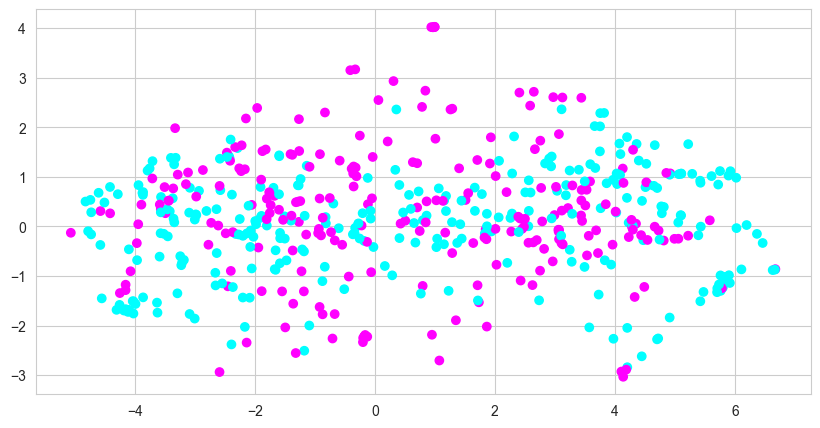

In [444]:
# https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c
X_tsne = TSNE(n_components=2, learning_rate=1000, n_iter=1000, perplexity=200).fit_transform(x)
X_pca = PCA().fit_transform(x)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:x.shape[0]], cmap='cool')
plt.savefig('normal_and_anomalies_2d.png', dpi=300)

### 3D Scatter plot (anomalies vs. normal)

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


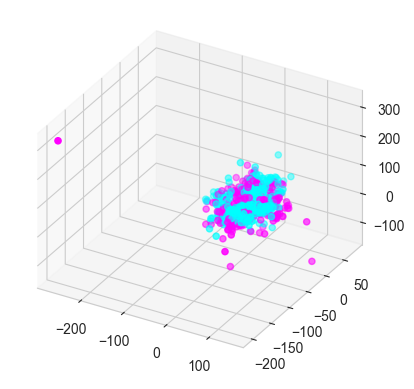

In [445]:
X_tsne = TSNE(n_components=3, learning_rate=250, n_iter=1000, perplexity=10).fit_transform(x)
X_pca = PCA().fit_transform(x)
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
# Data for three-dimensional scattered points
zdata = X_tsne[:, 0]
xdata = X_tsne[:, 1]
ydata = X_tsne[:, 2]
ax.set_proj_type('ortho')
ax.scatter3D(xdata, ydata, zdata, c=y[:x.shape[0]], cmap='cool')
plt.savefig('normal_and_anomalies_3d.png', dpi=300)

In [446]:
solution = [1.0, 0.641146679776725, 0.7628357076333331, 0.6605591709279424, 0.41749348815982157, 0.0688908841184559, 0.327681326083698]
solution = numpy.array(solution)
model = Autoencoder(solution, **config)
saving_path = config['logging_params']['save_dir'] + "manual_alg_" + model.hash_id
Path(saving_path).mkdir(parents=True, exist_ok=True)

+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+-----------------------------------------------------------+-----------------------------------------------------------+
|                    ID                    |  Shape (y1)   | Layer step (y2) | Layers (y3) | Activation func. (y4) | Epochs (y5) | Learning rate (y6) | Optimizer (y7) | Bottleneck size |                          Encoder                          |                          Decoder                          |
+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+-----------------------------------------------------------+-----------------------------------------------------------+
| a417f52c723bfa60569840bb1da12033214edf9c | A-SYMMETRICAL |       38        | 

In [447]:
#model.num_epochs = 3
early_stop_callback = EarlyStopping(monitor=config['early_stop']['monitor'],
                                    min_delta=config['early_stop']['min_delta'],
                                    patience=config['early_stop']['patience'],
                                    verbose=False,
                                    check_finite=True,
                                    mode="max")

experiment = DNNAEExperiment(model, config['exp_params'], config['model_params']['n_features'])
config['trainer_params']['max_epochs'] = model.num_epochs
tb_logger = TensorBoardLogger(save_dir=config['logging_params']['save_dir'],
                              name="manual_alg_" + model.hash_id)

runner = Trainer(logger=tb_logger,
                 enable_progress_bar=False,
                 # accelerator="gpu",
                 # devices=1,
                 # auto_select_gpus=True,
                 callbacks=[
                     LearningRateMonitor(),
                     ModelCheckpoint(save_top_k=1,
                                     dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
                                     monitor="val_loss",
                                     save_last=True),
                     early_stop_callback,
                 ],
                 # strategy=DDPPlugin(find_unused_parameters=False),
                 **config['trainer_params'])

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (RMSE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usi

Train and save mode to file

In [448]:
print(f"======= Training {config['model_params']['name']} =======")
print(f'\nTraining start: {datetime.now().strftime("%H:%M:%S-%d/%m/%Y")}')
#runner.fit(experiment, datamodule=datamodule)
print(f'\nTraining end: {datetime.now().strftime("%H:%M:%S-%d/%m/%Y")}')
torch.save(model.state_dict(), saving_path + "/manual_model.pt")

======= Training Autoencoder =======

Training start: 23:37:54-26/01/2023

Training end: 23:37:54-26/01/2023


Load model from file

In [449]:
model = Autoencoder(solution, **config)
#model.load_state_dict(torch.load(saving_path + "/manual_model.pt"))
model.load_state_dict(torch.load(
    "logs/model.pt"))
model.eval()

+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+-----------------------------------------------------------+-----------------------------------------------------------+
|                    ID                    |  Shape (y1)   | Layer step (y2) | Layers (y3) | Activation func. (y4) | Epochs (y5) | Learning rate (y6) | Optimizer (y7) | Bottleneck size |                          Encoder                          |                          Decoder                          |
+------------------------------------------+---------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+-----------------------------------------------------------+-----------------------------------------------------------+
| a417f52c723bfa60569840bb1da12033214edf9c | A-SYMMETRICAL |       38        | 

Autoencoder(
  (encoding_layers): ModuleList(
    (0): Linear(in_features=60, out_features=22, bias=True)
  )
  (decoding_layers): ModuleList(
    (0): Linear(in_features=22, out_features=60, bias=True)
  )
)

### Predict with loaded model

In [450]:
def predict(dataloader_iterator):
    rmse_list = list()
    mse_list = list()
    counter = 0
    for data, target in dataloader_iterator:
        data = data.to('cpu')
        reconstructed, input = model.forward(data)
        rmse = mean_squared_error(input.detach().numpy(), reconstructed.detach().numpy(), squared=True)
        mse = mean_squared_error(input.detach().numpy(), reconstructed.detach().numpy(), squared=False)
        rmse_list.append(rmse)
        mse_list.append(mse)
        counter += 1


    RMSE = round(sum(rmse_list) / len(rmse_list),2)
    MSE = round(sum(mse_list) / len(mse_list),2)
    return RMSE,MSE

In [451]:
RMSE,MSE = predict(iter(datamodule.val_dataloader()))
print(f"Val dataset evaluation:\nRMSE: {RMSE}, MSE: {MSE}")

RMSE,MSE = predict(iter(datamodule.train_dataloader()))
print(f"Train dataset evaluation:\nRMSE: {RMSE}, MSE: {MSE}")

RMSE,MSE = predict(iter(datamodule.test_dataloader()))
print(f"Test dataset evaluation:\nRMSE: {RMSE}, MSE: {MSE}")

Val dataset evaluation:
RMSE: 5.07, MSE: 1.38
Train dataset evaluation:
RMSE: 4.71, MSE: 1.39
Test dataset evaluation:
RMSE: 4.82, MSE: 1.4


### Calculate AUC value based on anomaly detection

In [452]:
anomaly_detection = AnomalyDetection([0], [1])
dataloader_iterator = iter(datamodule.test_dataloader())

inputs = []
outputs = []
scores = []
scores_mse = []
targets = []

"Loop over dataset"
for data, target in dataloader_iterator:
    data = data.to('cpu')
    reconstructed, input = model.forward(data)

    "Loop over batch"
    for x, y, z in zip(input, reconstructed, target):
        inputs.append(x)
        outputs.append(y)
        targets.append(z.item())
        score = torch.sqrt(torch.sum((y - x) ** 2, dim=tuple(range(1, y.dim()))))
        scores.append(score.cpu().data.numpy().tolist())
        mse = nn.MSELoss()(y,x)
        scores_mse.append(mse.cpu().data.numpy().tolist())

anomaly_detection.find(inputs, outputs, targets)
print(f"Model AUC score: {anomaly_detection.AUC}")

Model AUC score: 0.08762834636597978


In [453]:
# https://stackoverflow.com/questions/58894137/roc-auc-score-for-autoencoder-and-isolationforest
fpr = []
tpr = []
thresholds = []
roc_auc = []

fpr, tpr, thresholds = roc_curve(targets, scores)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.8537679468901657


In [454]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(optimal_threshold)

15.840375900268555


In [455]:
y_pred = []

for x in scores:
    if x <= optimal_threshold:
        y_pred.append(0)
    else:
        y_pred.append(1)

accuracy_score(targets, y_pred)

0.7924528301886793

Distance: 0.29


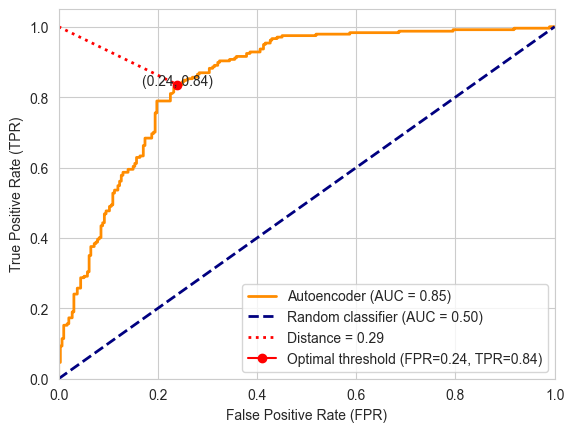

In [456]:
import math

plt.figure()
lw = 2
x = fpr[optimal_idx]
y = tpr[optimal_idx]

point1 = [0, 1]
point2 = [fpr[optimal_idx], tpr[optimal_idx]]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
distance = round(math.dist(point1, point2), 2)
print(f"Distance: {distance}")
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="Autoencoder (AUC = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--", label='Random classifier (AUC = 0.50)')
plt.plot(x_values, y_values, color="red", lw=lw, linestyle=":", label=f'Distance = {distance}')
plt.plot(x, y, '-ro', label=f'Optimal threshold (FPR={round(x,2)}, TPR={round(y,2)})')
x_values.pop(0)
y_values.pop(0)
for xy in zip(x_values, y_values):
   plt.annotate('(%.2f, %.2f)' % xy, xy=xy, ha='center')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
#plt.title("Performance of the optimal AE model for AD on fault detection dataset.")
plt.legend(loc="lower right")
plt.savefig('roc_curve.pdf')
plt.show()

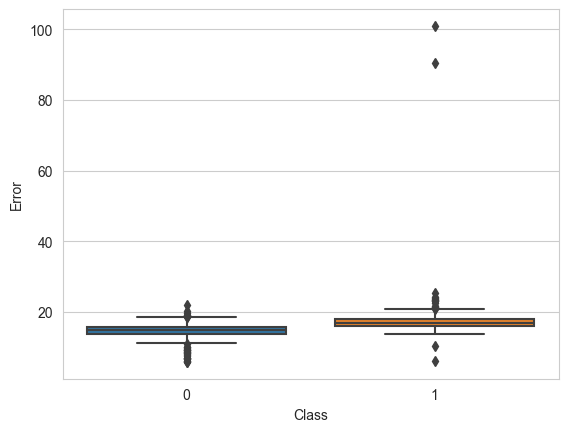

In [457]:
df = pd.DataFrame(list(zip(scores, targets)), columns=['Error', 'Class'])
df = df.round(1)
sns.boxplot(y=df["Error"], x=df["Class"])
plt.show()

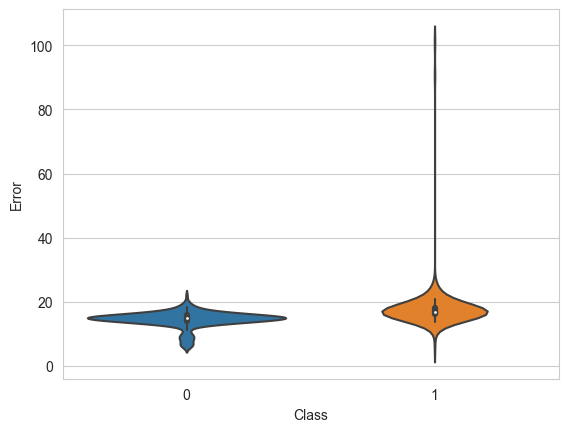

In [458]:
sns.violinplot(y=df["Error"], x=df["Class"], kind="kde")
plt.show()

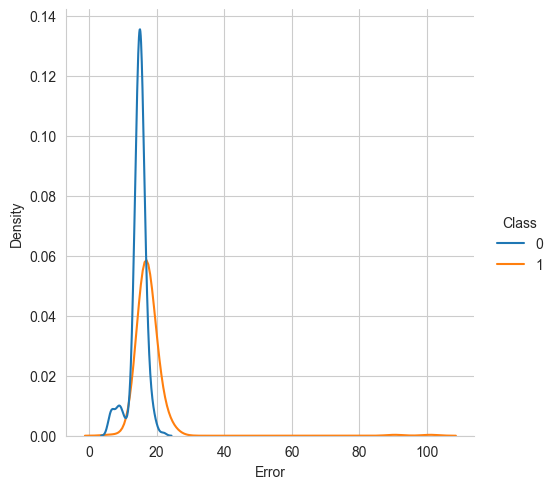

In [459]:
sns.displot(df, x="Error", hue="Class", kind="kde")
plt.show()

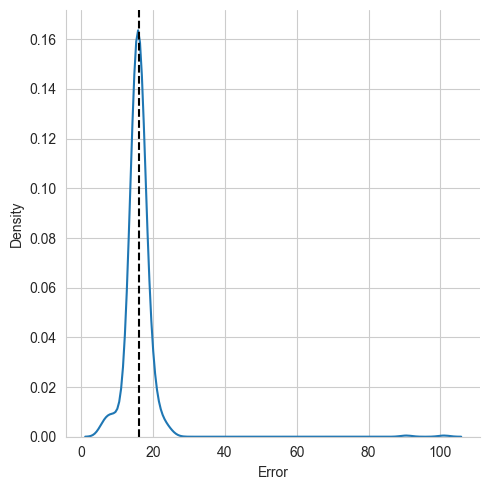

In [460]:
sns.displot(df, x="Error",  kind="kde")
plt.axvline(df['Error'].mean(), color='k', linestyle='--')
plt.show()

In [461]:
df.describe()

,Error,Class
count,530.000000,530.000000
mean,16.066038,0.447170
std,5.587951,0.497671
min,5.900000,0.000000
25%,14.700000,0.000000
50%,15.900000,0.000000
75%,17.000000,1.000000
max,101.000000,1.000000


In [462]:
df[df.Class == 0].describe()

,Error,Class
count,293.000000,293.0
mean,14.582594,0.0
std,2.456123,0.0
min,5.900000,0.0
25%,13.900000,0.0
50%,15.000000,0.0
75%,15.800000,0.0
max,22.000000,0.0


In [463]:
df[df.Class == 1].describe()

,Error,Class
count,237.000000,237.0
mean,17.900000,1.0
std,7.511212,0.0
min,6.300000,1.0
25%,16.100000,1.0
50%,16.800000,1.0
75%,18.000000,1.0
max,101.000000,1.0


In [464]:
df_grouped = df.groupby(['Error', 'Class'])['Error'].count()
df_grouped = df_grouped.reset_index(name='Count')

<AxesSubplot: xlabel='Count', ylabel='Error'>

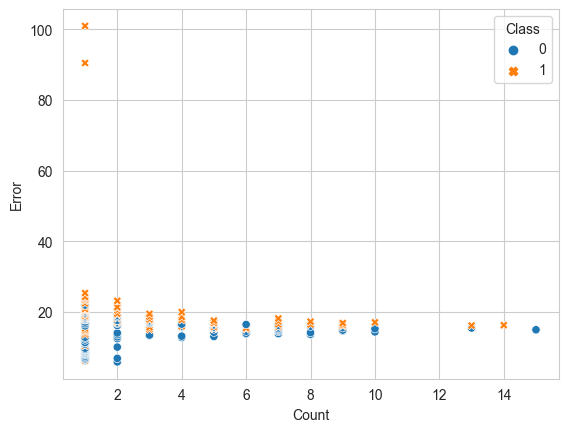

In [465]:
sns.scatterplot(data=df_grouped, x="Count", y="Error", hue="Class", style="Class")

### Loading data from database

In [466]:
# Create your connection.
cnx = sqlite3.connect('C:\\Users\\sasop\\PycharmProjects\\NiaNetHPC\\data\\solution_for_paper.db')

df_solutions = pd.read_sql_query("SELECT * FROM solutions", cnx)
cnx.commit()
cnx.close()
df_solutions.head(10)

,hash_id,timestamp,algorithm_name,iteration,encoding_layers,decoding_layers,topology_shape,num_layers,activation,num_epochs,learning_rate,optimizer,bottleneck_size,RMSE,AUC,complexity,fitness,solution_array
0,e68bd39ccb489375d53f2762001c5251ea38cbb6,23:32 11-12-2022,ParticleSwarmAlgorithm,1,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=14, out...",A-SYMMETRICAL,1,RELU,160,0.81,Adagrad,14,9.449935e+00,0.535,25840,9708,"[0.5494208183148553, 0.7742631420529832, 0.076..."
1,c9653f0037d63aca1196407a1c0d23895c30f5e2,23:35 11-12-2022,DifferentialEvolution,1,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=12, out...",A-SYMMETRICAL,1,CELU,110,0.98,SGD,12,2.043337e+09,0.500,12320,2043337472123,"[0.9879786337792499, 0.8079468801802399, 0.428..."
2,2766af509cde67b3ba8dfd4d51c86148735c1261,23:36 11-12-2022,ParticleSwarmAlgorithm,3,ModuleList(),ModuleList(),A-SYMMETRICAL,0,RELU,200,0.74,Empty,0,9.000000e+10,0.000,40000,90000000000400,"[0.5596647826627225, 0.4167355182299586, 0.417..."
3,b8b2de6ed86d35d36cac3273f9052d3ffcd70c3d,23:36 11-12-2022,SelfAdaptiveDifferentialEvolution,1,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=6, out_...",SYMMETRICAL,1,SELU,110,0.22,SGD,6,4.760105e+10,0.500,12260,47601053696122,"[0.02935405363396637, 0.9096925730268407, 0.32..."
4,1def402bb93e6e54f8512cd78444c90aeec4af8b,23:42 11-12-2022,DifferentialEvolution,2,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=28, out...",SYMMETRICAL,1,Leaky RELU,120,0.31,ASGD,28,9.000000e+10,0.000,14780,90000000000147,"[0.42081860469653065, 0.5499527099481752, 0.55..."
5,3da76b2fdfd05f2df44e79e3bd297a94eb71c526,23:43 11-12-2022,ParticleSwarmAlgorithm,4,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=4, out_...",A-SYMMETRICAL,1,Leaky RELU,180,0.44,Adam,4,7.073855e+00,0.656,32540,7399,"[0.9778317644535396, 0.934983981088478, 0.3352..."
6,1fc758f59c17dcb1a10ecb23c7fc8b988f34b509,23:43 11-12-2022,ParticleSwarmAlgorithm,5,ModuleList(),ModuleList(),A-SYMMETRICAL,0,CELU,140,0.04,Empty,0,9.000000e+10,0.000,19600,90000000000196,"[0.9210930778486106, 0.33520926044596067, 0.32..."
7,aa95497e563e10333d76efa2600073eca65c9d74,23:43 11-12-2022,SelfAdaptiveDifferentialEvolution,2,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=15, out...",SYMMETRICAL,1,GELU,170,0.74,RAdam,15,1.672989e+01,0.551,29150,17021,"[0.4321433527344134, 0.759021030265933, 0.1031..."
8,12ae243a68273e77e607361596df570a0c392a59,23:46 11-12-2022,FireflyAlgorithm,1,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=34, out...",A-SYMMETRICAL,1,SELU,180,0.61,SGD,34,2.138140e+01,0.539,32840,21709,"[0.6840036667016328, 0.4387454356511118, 0.771..."
9,1a40bca6ca2d954fa24fe5eb860a6742c407892a,23:51 11-12-2022,DifferentialEvolution,3,"ModuleList(\n (0): Linear(in_features=60, out...","ModuleList(\n (0): Linear(in_features=57, out...",A-SYMMETRICAL,6,ELU,140,0.37,RAdam,57,9.000000e+10,0.000,20770,90000000000207,"[0.8784213346547807, 0.05524944283559041, 0.34..."


In [467]:
#df_solutions.to_csv("solutions.csv", index=False)

### Smoothed AUC score over iterations for each algorithm

In [468]:
# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
x_values = []
y_values = []
z_values = []
algorithms = []
trends = []
means = []
deviations = []
import pymannkendall as mk

for algorithm in df_solutions.algorithm_name.unique():

    idx = df_solutions[(df_solutions['algorithm_name'] == algorithm) ].index
    df_filtered = df_solutions.loc[idx][['algorithm_name','timestamp',"iteration", "fitness", "AUC", 'RMSE']]

    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

    df_filtered.sort_values(by='timestamp',ascending=True)
    df_filtered['iteration']  = range(0, df_filtered.shape[0])

    df_filtered['AUC_mean'] = df_filtered['AUC'].expanding().mean()
    means.append(df_filtered['AUC_mean'].to_numpy())

    df_filtered['AUC_std'] = df_filtered['AUC'].expanding().std()
    deviations.append(df_filtered['AUC_std'].to_numpy())

    #trends.append(mk.original_test(df_filtered.AUC))
    #df_filtered['AUC'] = savgol_filter(df_filtered['AUC'], 300, 3)

    #df_filtered['fitness'] = df_filtered['fitness'] / df_filtered['fitness'].abs().max()
    df_filtered['RMSE'] = df_filtered['RMSE'] / df_filtered['RMSE'].abs().max()

    data = df_filtered.iteration.to_numpy()
    bin_edges, bin_counts = np.histogram(data, bins=100)
    bin_index = np.digitize(504, np.sort(bin_counts))

    x = df_filtered['iteration'].to_numpy()
    y = df_filtered['AUC'].to_numpy()
    z = df_filtered['RMSE'].to_numpy()

    x_values.append(x)
    y_values.append(y)
    z_values.append(z)
    algorithms.append(algorithm)

# fig = plt.figure(figsize=(10, 10))
# plt.xlabel('Iterations', fontsize=12)
# plt.ylabel('Smoothed AUC value', fontsize=12)
# plt.plot(x_values[0],y_values[0],label = algorithms[0] + "---" + trends[0].trend)
# plt.plot(x_values[1],y_values[1],label = algorithms[1] + "---" + trends[1].trend)
# plt.plot(x_values[2],y_values[2],label = algorithms[2] + "---" + trends[2].trend)
# plt.plot(x_values[3],y_values[3],label = algorithms[3] + "---" + trends[3].trend)
# plt.plot(x_values[4],y_values[4],label = algorithms[4] + "---" + trends[4].trend)
# plt.legend()
#
# plt.savefig(f'NiaNet.pdf')

### AUC score means by algorithm

#### Good if trend is increasing
#### Bad if trend is decreasing

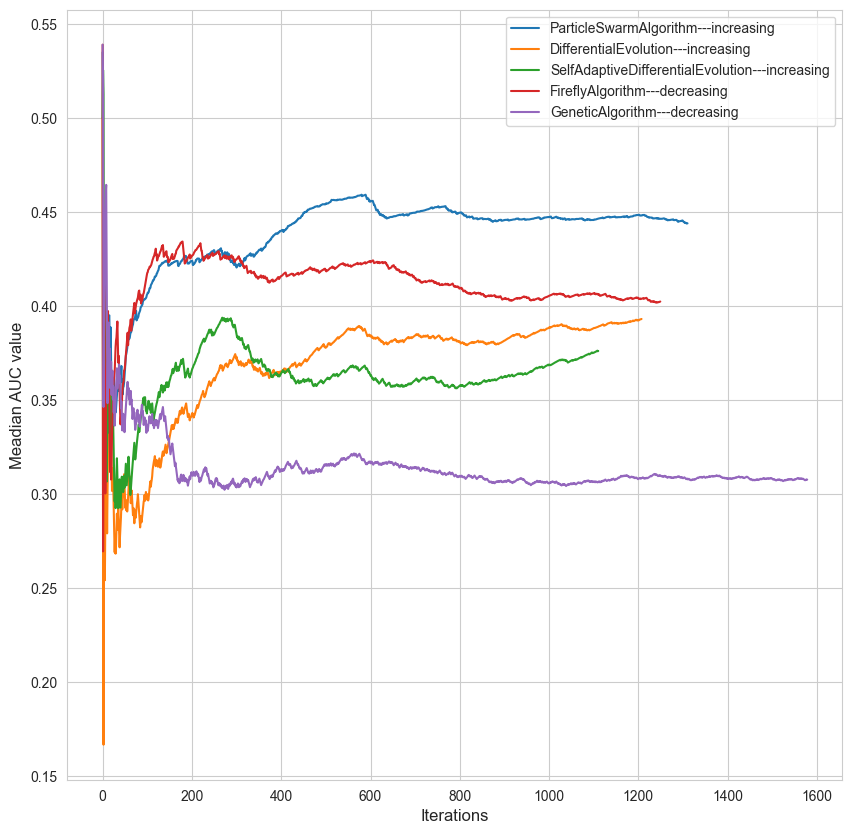

In [469]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Meadian AUC value', fontsize=12)
plt.plot(x_values[0],means[0],label = algorithms[0] + "---" + mk.original_test(means[0]).trend)
plt.plot(x_values[1],means[1],label = algorithms[1] + "---" + mk.original_test(means[1]).trend)
plt.plot(x_values[2],means[2],label = algorithms[2] + "---" + mk.original_test(means[2]).trend)
plt.plot(x_values[3],means[3],label = algorithms[3] + "---" + mk.original_test(means[3]).trend)
plt.plot(x_values[4],means[4],label = algorithms[4] + "---" + mk.original_test(means[4]).trend)

plt.legend()

### AUC score deviations by algorithm

#### Good if trend is decreasing
#### Bad if trend is increasing

'\nWhen calculating rolling statistics such as the standard deviation using the rolling() method in pandas, it is common to see the standard deviation jump or fluctuate in the beginning of the dataset. This is because the window size of the rolling calculation is typically smaller at the beginning of the dataset, which can lead to high volatility in the calculated statistic.\n'

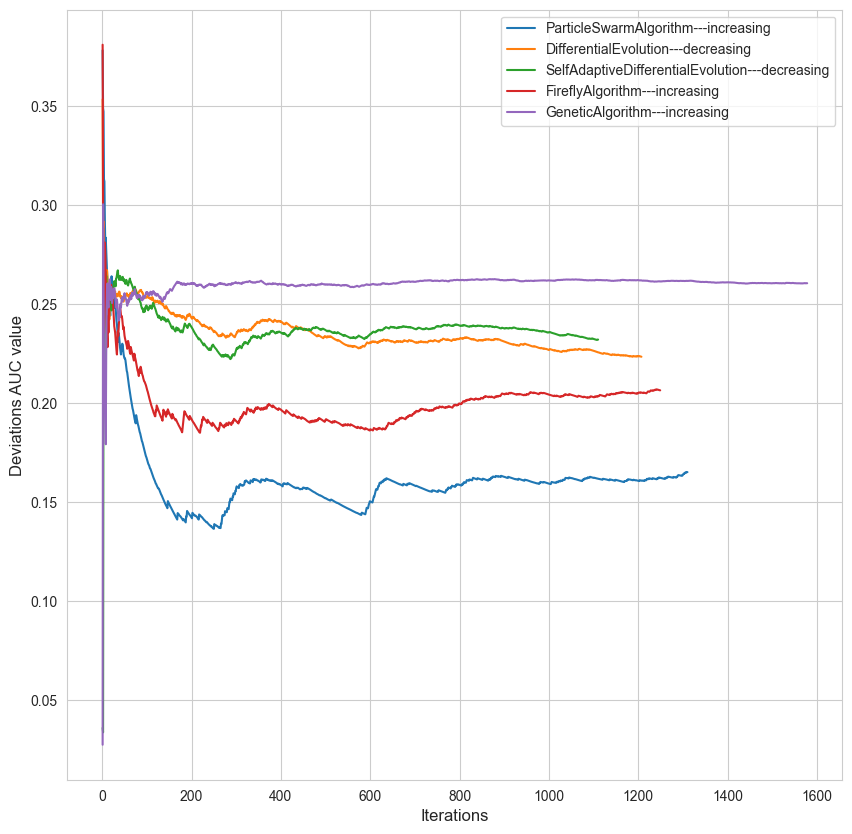

In [470]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Deviations AUC value', fontsize=12)
plt.plot(x_values[0],deviations[0],label = algorithms[0] + "---" + mk.original_test(deviations[0]).trend)
plt.plot(x_values[1],deviations[1],label = algorithms[1] + "---" + mk.original_test(deviations[1]).trend)
plt.plot(x_values[2],deviations[2],label = algorithms[2] + "---" + mk.original_test(deviations[2]).trend)
plt.plot(x_values[3],deviations[3],label = algorithms[3] + "---" + mk.original_test(deviations[3]).trend)
plt.plot(x_values[4],deviations[4],label = algorithms[4] + "---" + mk.original_test(deviations[4]).trend)

plt.legend()


"""
When calculating rolling statistics such as the standard deviation using the rolling() method in pandas, it is common to see the standard deviation jump or fluctuate in the beginning of the dataset. This is because the window size of the rolling calculation is typically smaller at the beginning of the dataset, which can lead to high volatility in the calculated statistic.
"""

C:\Users\sasop\AppData\Local\Temp\ipykernel_22476\3271243129.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_solutions.corr());


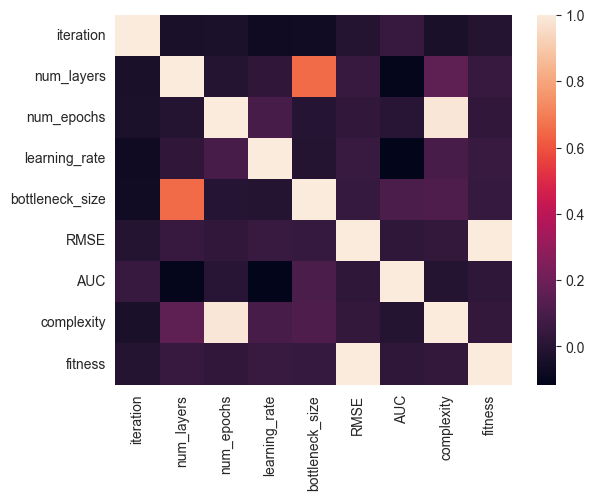

In [471]:
sns.heatmap(df_solutions.corr());

### Relationship between AUC score and RMSE

#### Filtered by solutions AUC !=0.00 AND RMSE < RMSE_Quatile(0.70)
#### This enables us to see relationships of optimal solutions

In [472]:
x_values = []
y_values = []
z_values = []
algorithms = []
dataframes = []
import random
for algorithm in df_solutions.algorithm_name.unique():

    idx = df_solutions[(df_solutions['algorithm_name'] == algorithm) & (df_solutions['AUC'] != 0.00) & (df_solutions.RMSE < df_solutions.RMSE.quantile(0.70))].index
    df_filtered = df_solutions.loc[idx][:]

    df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

    df_filtered.sort_values(by='timestamp',ascending=True)
    df_filtered['iteration']  = range(0, df_filtered.shape[0])


    #df_filtered['fitness'] = df_filtered['fitness'] / df_filtered['fitness'].abs().max()
    #df_filtered['AUC'] = df_filtered['AUC'] / df_filtered['AUC'].abs().max()
    #df_filtered['RMSE'] = df_filtered['RMSE'] / df_filtered['RMSE'].abs().max()

    dataframes.append(df_filtered.head(1000))

    x = df_filtered['iteration'].head(1000).to_numpy()
    y = df_filtered['AUC'].head(1000).to_numpy()
    z = df_filtered['RMSE'].head(1000).to_numpy()

    x_values.append(x)
    y_values.append(y)
    z_values.append(z)
    algorithms.append(algorithm)

C:\Users\sasop\AppData\Local\Temp\ipykernel_22476\2825117993.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = dataframes[0].append(dataframes[1]).append(dataframes[2]).append(dataframes[3]).append(dataframes[4])
C:\Users\sasop\AppData\Local\Temp\ipykernel_22476\2825117993.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = dataframes[0].append(dataframes[1]).append(dataframes[2]).append(dataframes[3]).append(dataframes[4])
C:\Users\sasop\AppData\Local\Temp\ipykernel_22476\2825117993.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = dataframes[0].append(dataframes[1]).append(dataframes[2]).append(dataframes[3]).append(dataframes[4])
C:\Users\sasop\AppData\Local\Temp\ipykernel_22

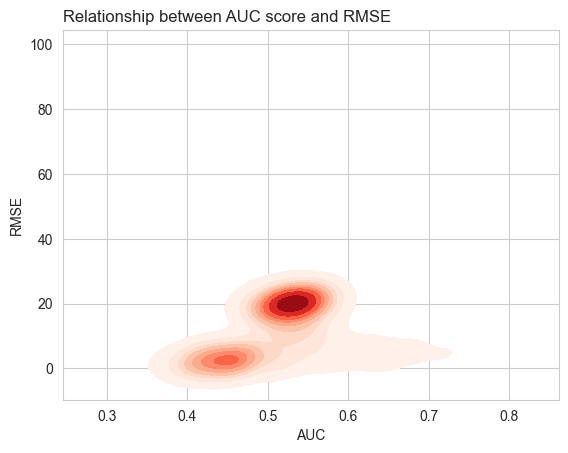

In [473]:
df_combined = dataframes[0].append(dataframes[1]).append(dataframes[2]).append(dataframes[3]).append(dataframes[4])
df_combined=df_combined.sample(1000)
sns.kdeplot(data = df_combined, x="AUC", y="RMSE", cmap="Reds", shade=True)
plt.title('Relationship between AUC score and RMSE', loc='left')
plt.show()

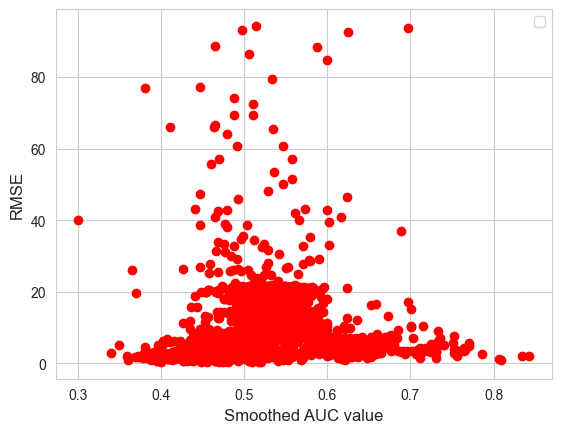

In [474]:
#sns.scatterplot(data=df_filtered, x="AUC", y="RMSE", hue="algorithm_name", style="algorithm_name")
plt.xlabel('Smoothed AUC value', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.scatter(y_values[0],z_values[0],color = "red")
plt.scatter(y_values[1],z_values[1],color = "red")
plt.scatter(y_values[2],z_values[2],color = "red")
plt.scatter(y_values[3],z_values[3],color = "red")
plt.scatter(y_values[4],z_values[4],color = "red")
plt.legend()

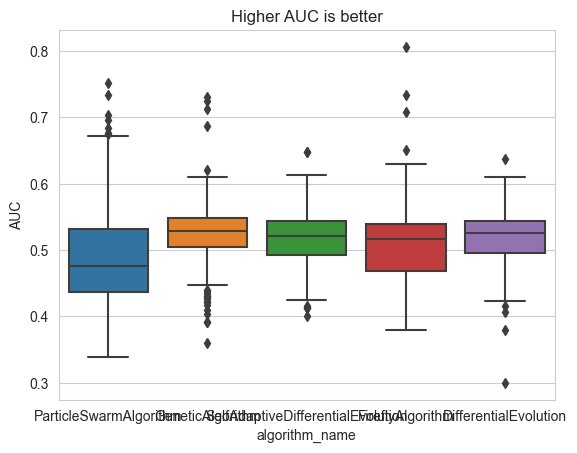

In [475]:
sns.boxplot(y=df_combined["AUC"], x=df_combined['algorithm_name'])
plt.title('Higher AUC is better')
plt.show()

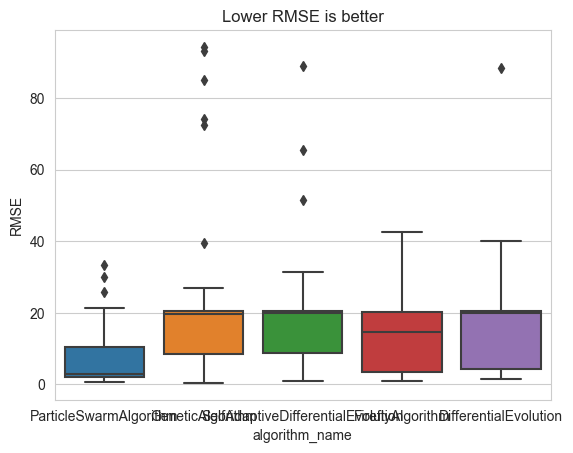

In [476]:
sns.boxplot(y=df_combined["RMSE"], x=df_combined['algorithm_name'])
plt.title('Lower RMSE is better')
plt.show()

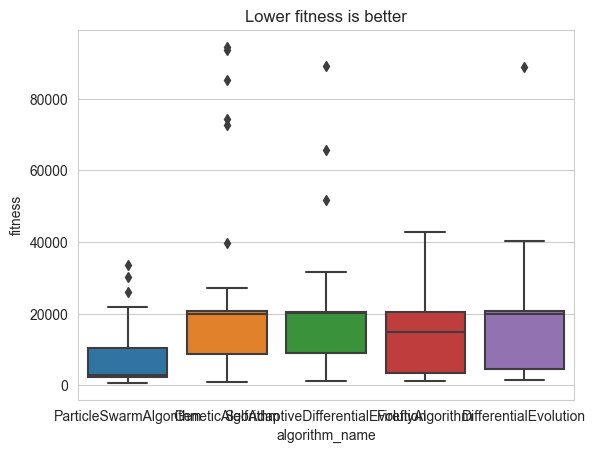

In [477]:
sns.boxplot(y=df_combined["fitness"], x=df_combined['algorithm_name'])
plt.title('Lower fitness is better')
plt.show()

In [ ]:
sns.pairplot(df_combined[["iteration","AUC","fitness","RMSE", "complexity"]],kind="kde")

In [ ]:
sns.kdeplot(data = df_combined, x="iteration", y="complexity", cmap="Reds", shade=True)
plt.title('Relationship between iteration score and complexity', loc='left')
plt.show()

In [ ]:
sns.kdeplot(data = df_combined, x="complexity", y="AUC", cmap="Reds", shade=True)
plt.title('Relationship between AUC score and complexity', loc='left')
plt.show()

In [ ]:
sns.pairplot(df_combined[["RMSE", "bottleneck_size"]],kind="kde")